# 推荐评论展示任务

# 任务描述 

本次推荐评论展示任务的目标是从真实的用户评论中，挖掘合适作为推荐理由的短句。点评软件展示的推荐理由具有长度限制，而真实用户评论语言通顺、信息完整。综合来说，两者都具有用户情感的正负向，但是展示推荐理由的内容相关性高于评论，需要较强的文本吸引力。一些真实的推荐理由如下图所示：

![推荐理由](https://boyuai.oss-cn-shanghai.aliyuncs.com/disk/YouthAI%E7%A7%8B%E5%AD%A3%E6%80%9D%E7%BB%B4%E7%8F%AD-%E4%B8%8A%E8%AF%BE%E8%A7%86%E9%A2%91/textcls_pic/apppic.png)



# 数据集

本次推荐评论展示任务所采用的数据集是点评软件中，用户中文评论的集合。


## 数据样例
本次任务要求将这些评论分为两类，即“展示”和“不展示”，分别以数字1和0作为标注，如下图所示：


![数据样例](https://boyuai.oss-cn-shanghai.aliyuncs.com/disk/YouthAI%E7%A7%8B%E5%AD%A3%E6%80%9D%E7%BB%B4%E7%8F%AD-%E4%B8%8A%E8%AF%BE%E8%A7%86%E9%A2%91/textcls_pic/dataexp.png)

## 文档说明 


数据集文件分为训练集和测试集部分，对应文件如下：

- 带标签的训练数据：`train_shuffle.txt` 
- 不带标签的测试数据：`test_handout.txt`

注意，`test_handout.txt`文件的行索引从0开始，对应于ID一列，评论内容为“展示”的预测概率应于Prediction一列。

需要注意的是，由于数据在标注时存在主观偏好，标记为“不展示”（0）的评论不一定是真正的负面评论，反之亦然。但是这种情况的存在，不会对任务造成很大的歧义，通过基准算法我们可以在测试集上实现很高的性能。

# 任务拆解

推荐评论展示任务需要对数据集中的评论文本文件进行处理，传统的学习方式流程为：

![学习流程](https://boyuai.oss-cn-shanghai.aliyuncs.com/disk/YouthAI%E7%A7%8B%E5%AD%A3%E6%80%9D%E7%BB%B4%E7%8F%AD-%E4%B8%8A%E8%AF%BE%E8%A7%86%E9%A2%91/textcls_pic/method.png)

对于以上的任务，近年来兴起的深度学习算法都可以实现：

![学习流程](https://boyuai.oss-cn-shanghai.aliyuncs.com/disk/YouthAI%E7%A7%8B%E5%AD%A3%E6%80%9D%E7%BB%B4%E7%8F%AD-%E4%B8%8A%E8%AF%BE%E8%A7%86%E9%A2%91/textcls_pic/deepmethod.png)

# 评估说明

## 评价指标

本次任务采用 [AUC（Area Under Curve)](https://baike.baidu.com/item/AUC/19282953) 作为模型的评价标准。

## 在线评估

评估函数首先会验证选手提交的预测结果文件是否符合要求，主要验证了以下要求:

1. 提交的预测文件是否存在重复ID
2. 提交的预测文件ID是否与测试集文件ID不匹配
3. 提交的预测文件Prediction列是否存在整数（auc测评要求选手提供的是概率值，而非分类结果0或1）

通过验证后的文件会用以AUC为测评指标的函数进行计算评估。


## 文件格式

由于测评脚本已经统一，为保证脚本的顺利运行，在进行测评时，要求选手提交的`预测文件`拥有规范的字段名和字段格式，预测文件具体要求如下：

| NO | 字段名称 | 数据类型 | 字段描述 |
| -------- | -------- | -------- | -------- |
| 1    | ID     | int    | ID序列     |
| 2    | Prediction   | float     | 预测结果（概率值）   |

正确格式的提交文件样例: `submission_random.csv`。

## 基准算法

本次任务采用不同的基准算法，获得模型的AUC如下：
- 随机基准算法AUC：0.51209
- 弱基准算法AUC：0.85107
- 强基准算法AUC：0.94452
在评估时，以弱基准算法的AUC作为达标线。


## 终审评估

本次任务的终审评估将挑选在评分指标位于前10名的同学进行项目报告撰写，以描述模型、算法及实验等相关内容和结果，报告排版要求届时发布。

除此以外，为保证竞赛的公平性，进入终审评估的同学需要提交项目代码，由助教进行模型的有效性验证。

如发现实验结果有较大差异，或者模型无法复现等问题，组委会将取消营员本次14天陪你挑战《动手学深度学习》的结营资格，并且进行公示。

In [1]:
import pandas as pd
import collections
import os
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import random
import matplotlib.pyplot as pyplot
import time
from tqdm import tqdm
import torch
from torch import nn
import torchtext.vocab as Vocab
import torch.utils.data as Data
import torch.nn.functional as F
import nltk
import jieba
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data_train = pd.read_csv("data_train.csv", encoding='gbk')
data_train.rename(columns={'0':'label', '1':'comment'}, inplace=True)

In [3]:
data_train.head()

,label,comment
0,0,酸菜鱼不错
1,0,轻食素食都是友善的饮食方式
2,0,完爆中午吃的农家乐
3,1,烤鱼很入味
4,0,有种入口即化的感觉


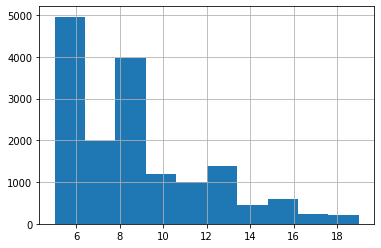

In [4]:
data_train['length'] = data_train['comment'].apply(lambda x: len(x))
data_train['length'].hist()
pyplot.show()

In [5]:
data_test = pd.read_csv("data_test.csv", encoding='gbk')
data_test.rename(columns={'0':'comment'}, inplace=True)

In [6]:
data_test.head()

,comment
0,理由很简单
1,蘸着花生酱吃非常美味
2,味道奶香味恰到好处
3,面包片烤的恰到好处
4,属于简单经济型


In [7]:
train_comment_list = list(data_train['comment'])
test_comment_list = list(data_test['comment'])
train_label = list(data_train['label'])

In [8]:
def tokenize(sentences, token='word'):
    """Split sentences into word or char tokens"""
    if token == 'word':
        return [jieba.lcut(sentence, cut_all=False) for sentence in sentences]
    elif token == 'char':
        return [list(sentence) for sentence in sentences]
    else:
        print('ERROR: unkown token type '+token)

In [9]:
train_tokenize = tokenize(train_comment_list, token='char')
test_tokenize = tokenize(test_comment_list, token='char')

In [10]:
train_tokenize[0:5]

[['酸', '菜', '鱼', '不', '错'],
 ['轻', '食', '素', '食', '都', '是', '友', '善', '的', '饮', '食', '方', '式'],
 ['完', '爆', '中', '午', '吃', '的', '农', '家', '乐'],
 ['烤', '鱼', '很', '入', '味'],
 ['有', '种', '入', '口', '即', '化', '的', '感', '觉']]

In [11]:
counter = collections.Counter([word for sentence in train_comment_list for word in sentence])
vocab = Vocab.Vocab(counter)

In [12]:
def preprocess(tokenized_data, vocab):
    '''
    @params:
        data: 同上，原始的读入数据
        vocab: 训练集上生成的词典
    @return:
        features: 单词下标序列，形状为 (n, max_l) 的整数张量
        labels: 情感标签，形状为 (n,) 的0/1整数张量
    '''
    max_l = 19 # 将每条评论通过截断或者补0，使得长度变成500
    #从原理上面讲，其实可以不用文本进行等长的划分，但是为了训练方便，更好的并行化处理
    def pad(x):
        return x[:max_l] if len(x) > max_l else x + [0] * (max_l - len(x))
    #将文本转换成 tensor.long的格式
    features = torch.tensor([pad([vocab.stoi[word] for word in words]) for words in tokenized_data])
    return features

In [13]:
train_data =  preprocess(train_comment_list, vocab)
test_data = preprocess(test_comment_list, vocab)
train_label = torch.tensor(train_label)

In [14]:
train_all_set = Data.TensorDataset(train_data, train_label)
#划分训练集合以及测试集合
train_set, val_set = torch.utils.data.random_split(train_all_set, [int(0.9*len(data_train)), len(data_train)-int(0.9*len(data_train))])

In [15]:
batch_size = 64
train_iter = Data.DataLoader(train_set, batch_size, shuffle=True)
val_iter = Data.DataLoader(val_set, batch_size)

In [22]:
class BiRNN(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_layers):
        '''
        @params:
            vocab: 在数据集上创建的词典，用于获取词典大小
            embed_size: 嵌入维度大小
            num_hiddens: 隐藏状态维度大小
            num_layers: 隐藏层个数
        '''
        super(BiRNN, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size)
        # encoder-decoder framework
        # bidirectional设为True即得到双向循环神经网络
        self.encoder = nn.LSTM(input_size=embed_size, 
                                hidden_size=num_hiddens, 
                                num_layers=num_layers,
                                bidirectional=True)
        self.decoder = nn.Linear(4*num_hiddens, 2) # 初始时间步和最终时间步的隐藏状态作为全连接层输入

    def forward(self, inputs):
        '''
        @params:
            inputs: 词语下标序列，形状为 (batch_size, seq_len) 的整数张量
        @return:
            outs: 对文本情感的预测，形状为 (batch_size, 2) 的张量
        '''
        # 因为LSTM需要将序列长度(seq_len)作为第一维，所以需要将输入转置
        embeddings = self.embedding(inputs) # (seq_len, batch_size, d)
        embeddings = embeddings.transpose(0,1) # (seq_len, batch_size, d)
        # rnn.LSTM 返回输出、隐藏状态和记忆单元，格式如 outputs, (h, c)
        outputs, _ = self.encoder(embeddings) # (seq_len, batch_size, 2*h)
        encoding =  torch.cat((outputs[0], outputs[-1]), -1) # (batch_size, 4*h)
        outs = self.decoder(encoding) # (batch_size, 2)
        return outs
embed_size, num_hiddens, num_layers = 100, 64, 1
net = BiRNN(vocab, embed_size, num_hiddens, num_layers)

In [23]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        device = list(net.parameters())[0].device 
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(net, torch.nn.Module):
                net.eval()
                acc_sum += (net(X.to(device)).argmax(dim=1) == y.to(device)).float().sum().cpu().item()
                net.train()
            else:
                if('is_training' in net.__code__.co_varnames):
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
    return acc_sum / n
def train(train_iter, test_iter, net, loss, optimizer, device, num_epochs):
    net = net.to(device)
    print("training on ", device)
    batch_count = 0
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y) 
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_l_sum += l.cpu().item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().cpu().item()
            n += y.shape[0]
            batch_count += 1
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / batch_count, train_acc_sum / n, test_acc, time.time() - start))

In [24]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()
train(train_iter, val_iter, net, loss, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.4092, train acc 0.803, test acc 0.871, time 1.4 sec
epoch 2, loss 0.1322, train acc 0.893, test acc 0.876, time 1.3 sec
epoch 3, loss 0.0752, train acc 0.911, test acc 0.884, time 1.3 sec
epoch 4, loss 0.0477, train acc 0.925, test acc 0.874, time 1.3 sec
epoch 5, loss 0.0326, train acc 0.937, test acc 0.885, time 1.3 sec


In [38]:
#采用text cnn进行分类
class GlobalMaxPool1d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool1d, self).__init__()
    def forward(self, x):
        '''
        @params:
            x: 输入，形状为 (batch_size, n_channels, seq_len) 的张量
        @return: 时序最大池化后的结果，形状为 (batch_size, n_channels, 1) 的张量
        '''
        return F.max_pool1d(x, kernel_size=x.shape[2]) # kenerl_size=seq_len
class TextCNN(nn.Module):
    def __init__(self, vocab, embed_size, kernel_sizes, num_channels):
        '''
        @params:
            vocab: 在数据集上创建的词典，用于获取词典大小
            embed_size: 嵌入维度大小
            kernel_sizes: 卷积核大小列表
            num_channels: 卷积通道数列表
        '''
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(len(vocab), embed_size) # 参与训练的嵌入层
        self.constant_embedding = nn.Embedding(len(vocab), embed_size) # 不参与训练的嵌入层
        
        self.pool = GlobalMaxPool1d() # 时序最大池化层没有权重，所以可以共用一个实例
        self.convs = nn.ModuleList()  # 创建多个一维卷积层
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(in_channels = 2*embed_size, 
                                        out_channels = c, 
                                        kernel_size = k))
            
        self.decoder = nn.Linear(sum(num_channels), 2)
        self.dropout = nn.Dropout(0.5) # 丢弃层用于防止过拟合

    def forward(self, inputs):
        '''
        @params:
            inputs: 词语下标序列，形状为 (batch_size, seq_len) 的整数张量
        @return:
            outputs: 对文本情感的预测，形状为 (batch_size, 2) 的张量
        '''
        embeddings = torch.cat((
            self.embedding(inputs), 
            self.constant_embedding(inputs)), dim=2) # (batch_size, seq_len, 2*embed_size)
        # 根据一维卷积层要求的输入格式，需要将张量进行转置
        #transpose只能每次交换两维，而permute可以针对多维进行交换
        embeddings = embeddings.permute(0, 2, 1) # (batch_size, 2*embed_size, seq_len)
        encoding = torch.cat([
            self.pool(F.relu(conv(embeddings))).squeeze(-1) for conv in self.convs], dim=1)
        # encoding = []
        # for conv in self.convs:
        #     out = conv(embeddings) # (batch_size, out_channels, seq_len-kernel_size+1)
        #     out = self.pool(F.relu(out)) # (batch_size, out_channels, 1)
        #     encoding.append(out.squeeze(-1)) # (batch_size, out_channels)
        # encoding = torch.cat(encoding) # (batch_size, out_channels_sum)
        
        # 应用丢弃法后使用全连接层得到输出
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [41]:
embed_size, kernel_sizes, nums_channels = 64, [3, 4, 5], [128, 128, 128]
net = TextCNN(vocab, embed_size, kernel_sizes, nums_channels)

In [42]:
lr, num_epochs = 0.001, 10
optimizer = torch.optim.Adam( net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()
train(train_iter, val_iter, net, loss, optimizer, device, num_epochs)

training on  cuda
epoch 1, loss 0.4013, train acc 0.823, test acc 0.891, time 1.4 sec
epoch 2, loss 0.1436, train acc 0.881, test acc 0.890, time 1.3 sec
epoch 3, loss 0.0828, train acc 0.898, test acc 0.885, time 1.4 sec
epoch 4, loss 0.0543, train acc 0.911, test acc 0.894, time 1.3 sec
epoch 5, loss 0.0385, train acc 0.923, test acc 0.878, time 1.3 sec
epoch 6, loss 0.0277, train acc 0.933, test acc 0.896, time 1.3 sec
epoch 7, loss 0.0211, train acc 0.942, test acc 0.891, time 1.3 sec
epoch 8, loss 0.0168, train acc 0.949, test acc 0.889, time 1.3 sec
epoch 9, loss 0.0138, train acc 0.952, test acc 0.896, time 1.3 sec
epoch 10, loss 0.0109, train acc 0.959, test acc 0.898, time 1.3 sec


In [33]:
with torch.no_grad():
    net.eval()
    test_pred = net(test_data.cuda())
    test_pred = F.softmax(test_pred).cpu()

/home/jiangfuxin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


In [34]:
test_label = test_pred.argmax(dim=1).numpy()
print(collections.Counter(test_label))

Counter({0: 2828, 1: 1361})


In [35]:
test_pred = test_pred.numpy()

In [36]:
submission_random = pd.DataFrame({})
submission_random['ID'] = range(test_pred.shape[0])
submission_random['Prediction'] = test_pred[:,1]

In [37]:
submission_random.to_csv("submission_random.csv", index=False)